In [1]:
import cv2
import numpy as np
from numpy.core.defchararray import join, mod
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import os
import torch
from torch._C import device
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_mobilenet_v3_large_fpn,fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.rpn import AnchorGenerator
from PIL import Image
from torchvision import transforms as torchtrans
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
!git clone https://github.com/MaharshiErata/TheOGTeam.git

Cloning into 'TheOGTeam'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 33 (delta 5), reused 22 (delta 3), pack-reused 8
Receiving objects: 100% (33/33), 134.66 MiB | 18.97 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (8/8), done.
Filtering content: 100% (4/4), 709.25 MiB | 51.72 MiB/s, done.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/TheOGTeam/dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/labels/armas (904).txt  
  inflating: /content/dataset/train/labels/armas (915).txt  
  inflating: /content/dataset/train/labels/armas (916).txt  
  inflating: /content/dataset/train/labels/armas (917).txt  
  inflating: /content/dataset/train/labels/armas (919).txt  
  inflating: /content/dataset/train/labels/armas (923).txt  
  inflating: /content/dataset/train/labels/armas (925).txt  
  inflating: /content/dataset/train/labels/armas (926).txt  
  inflating: /content/dataset/train/labels/armas (927).txt  
  inflating: /content/dataset/train/labels/armas (932).txt  
  inflating: /content/dataset/train/labels/armas (937).txt  
  inflating: /content/dataset/train/labels/armas (94).txt  
  inflating: /content/dataset/train/labels/armas (941).txt  
  inflating: /content/dataset/train/labels/armas (943).txt  
  inflating: /content/dataset/train/labels/armas (945).txt  
  inflating: /content/dataset/train

In [5]:
def load_test_img(image_path):
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = img_rgb/255
        img_res = torch.as_tensor(img_res).to(device)
        img_res = img_res.permute(2, 0, 1)
        return img_res

def apply_nms(orig_prediction, iou_thresh=None):


   # torchvision returns the indices of the bboxes to keep
   keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)


   final_prediction = orig_prediction
   final_prediction['boxes'] = final_prediction['boxes'][keep]
   final_prediction['scores'] = final_prediction['scores'][keep]
   final_prediction['labels'] = final_prediction['labels'][keep]


   return final_prediction


# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
   return torchtrans.ToPILImage()(img).convert('RGB')


def plot_img_bbox(img, target):
   # plot the image and bboxes
   # Bounding boxes are defined as follows: x-min y-min width height
   fig, a = plt.subplots(1, 1)
   fig.set_size_inches(5, 5)
   a.imshow(img)


   # Detach the tensor before using it in numpy()
   for box in target['boxes'].detach().cpu().numpy():
       x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
       rect = patches.Rectangle((x, y),
                                width, height,
                                linewidth=2,
                                edgecolor='r',
                                facecolor='none')


       # Draw the bounding box on top of the image
       a.add_patch(rect)


   plt.show()

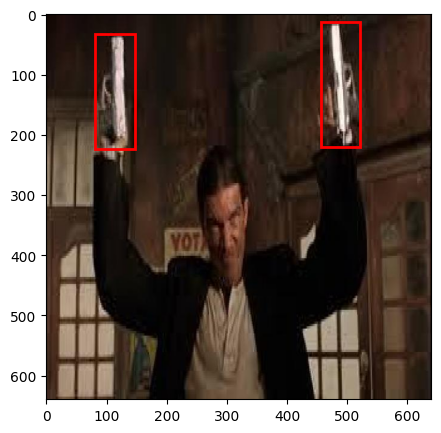

In [6]:
MODEL_SAVE_PATH1 = "/content/TheOGTeam/Models/WeaponDetection_10_resnet.pt"
MODEL_SAVE_PATH2 = "/content/TheOGTeam/Models/mobilenet_10.pt"
MODEL_SAVE_PATH3 = "/content/TheOGTeam/Models/mobilenet_20.pt"
MODEL_SAVE_PATH4 = "/content/TheOGTeam/Models/WeaponDetection_10_resnet2.0.pt"

model=torch.load(MODEL_SAVE_PATH2)
test_path = "/content/dataset/test/images/67fcce43-312_jpeg_jpg.rf.250e1320bc7ee7704df530b952e8f968.jpg"
# test_path = "/content/dataset/test/images/FILE280_JPG_jpg.rf.0aabbe6284c929065e46cd54c8851558.jpg"
# test_path = "/content/dataset/test/images/PUBGGunsInRealLife-06791_jpg.rf.068f5467a04fd696475901faccad0781.jpg"
test_data = load_test_img(test_path)
model.eval()
outputs = model([test_data])
outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]

nms_prediction = apply_nms(outputs[0], iou_thresh=0.7)

plot_img_bbox(torch_to_pil(test_data), nms_prediction)